# Imputación de datos faltantes

**Librerías**:

In [1]:
import janitor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

In [2]:
%run pandas-missing-extension.ipynb

## Preparando datos: _National Health and Nutrition Examination Survey_

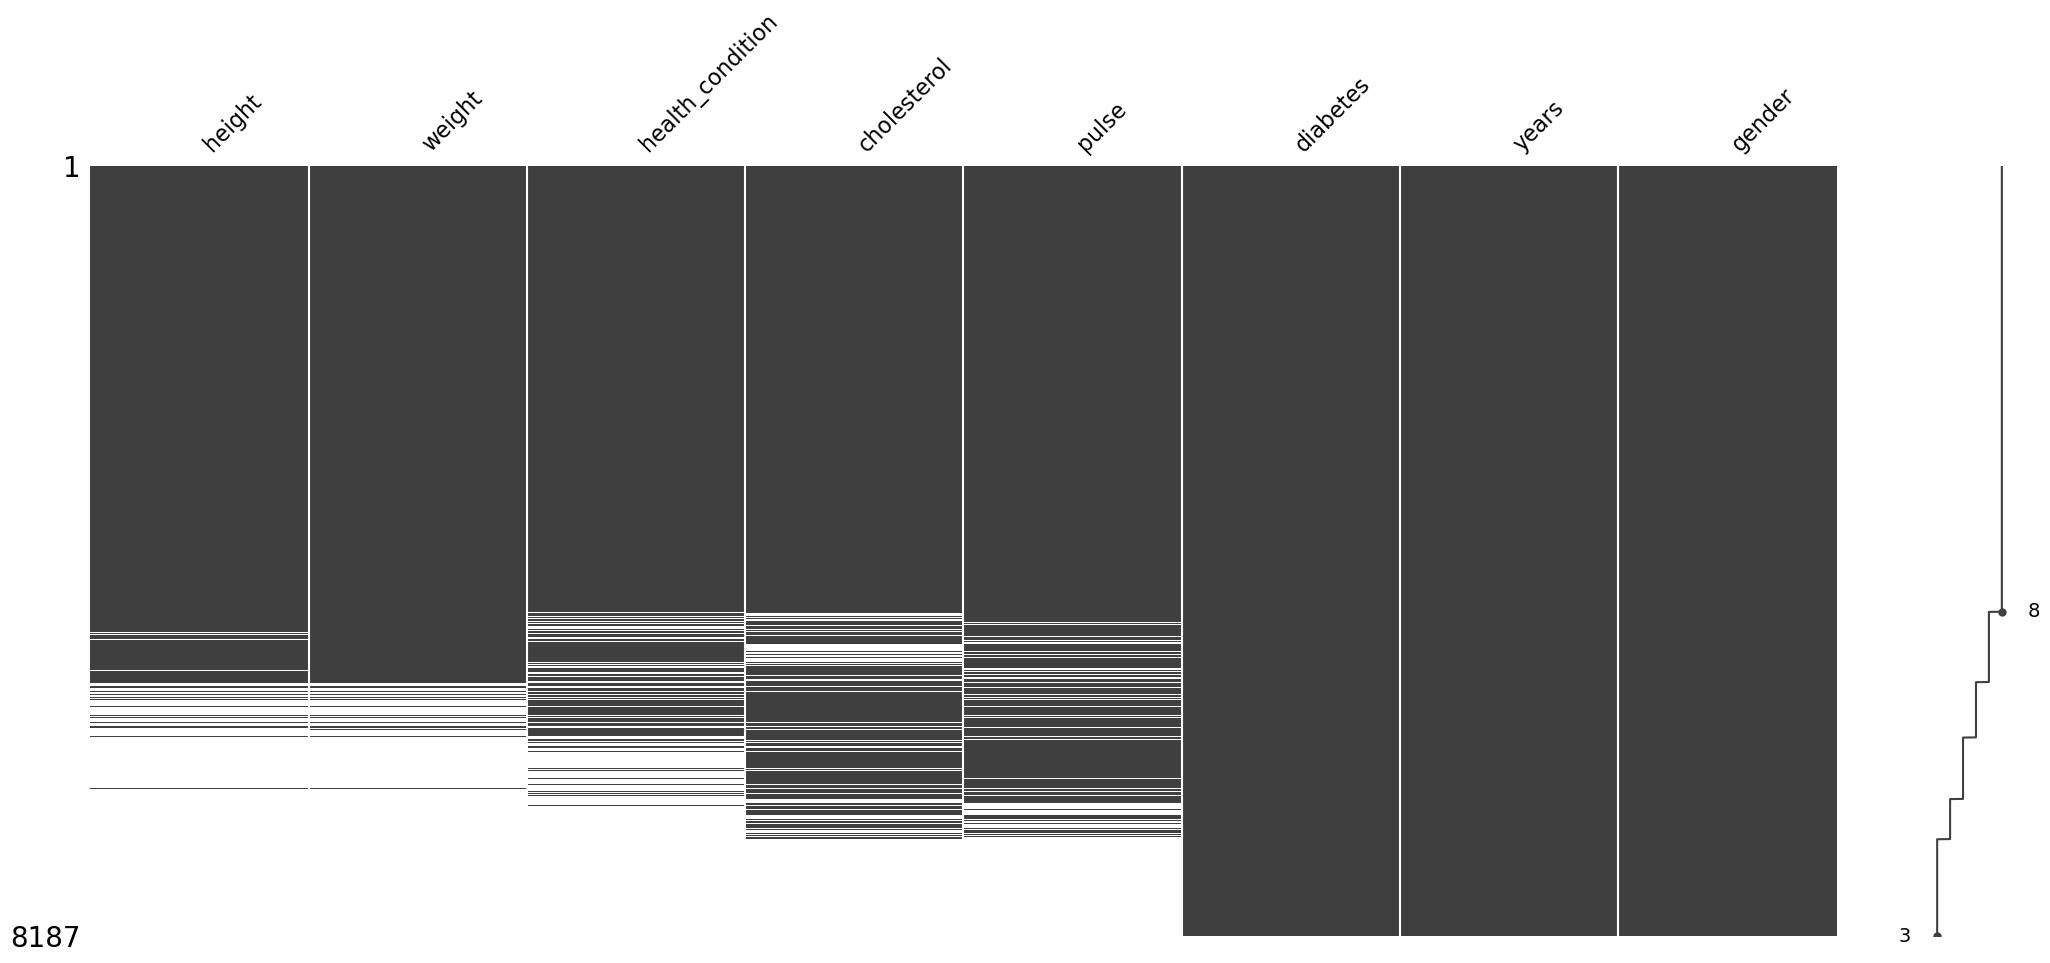

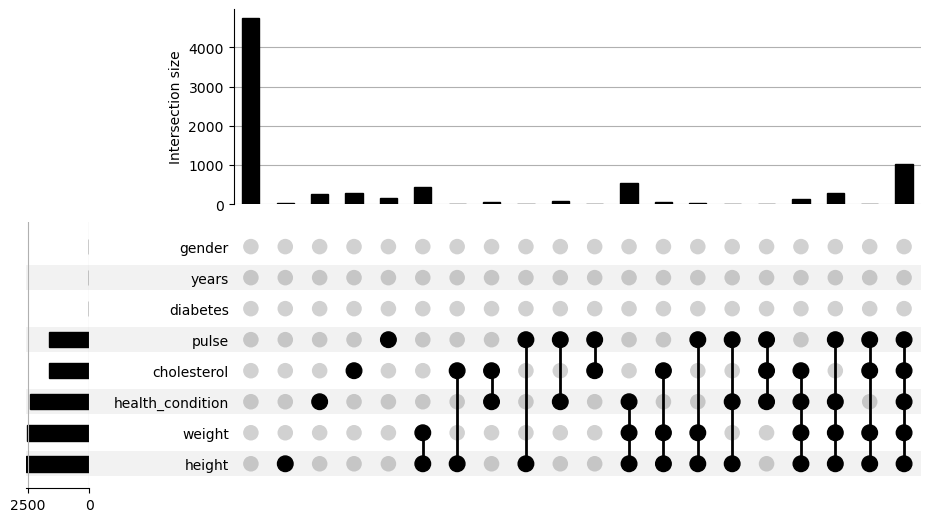

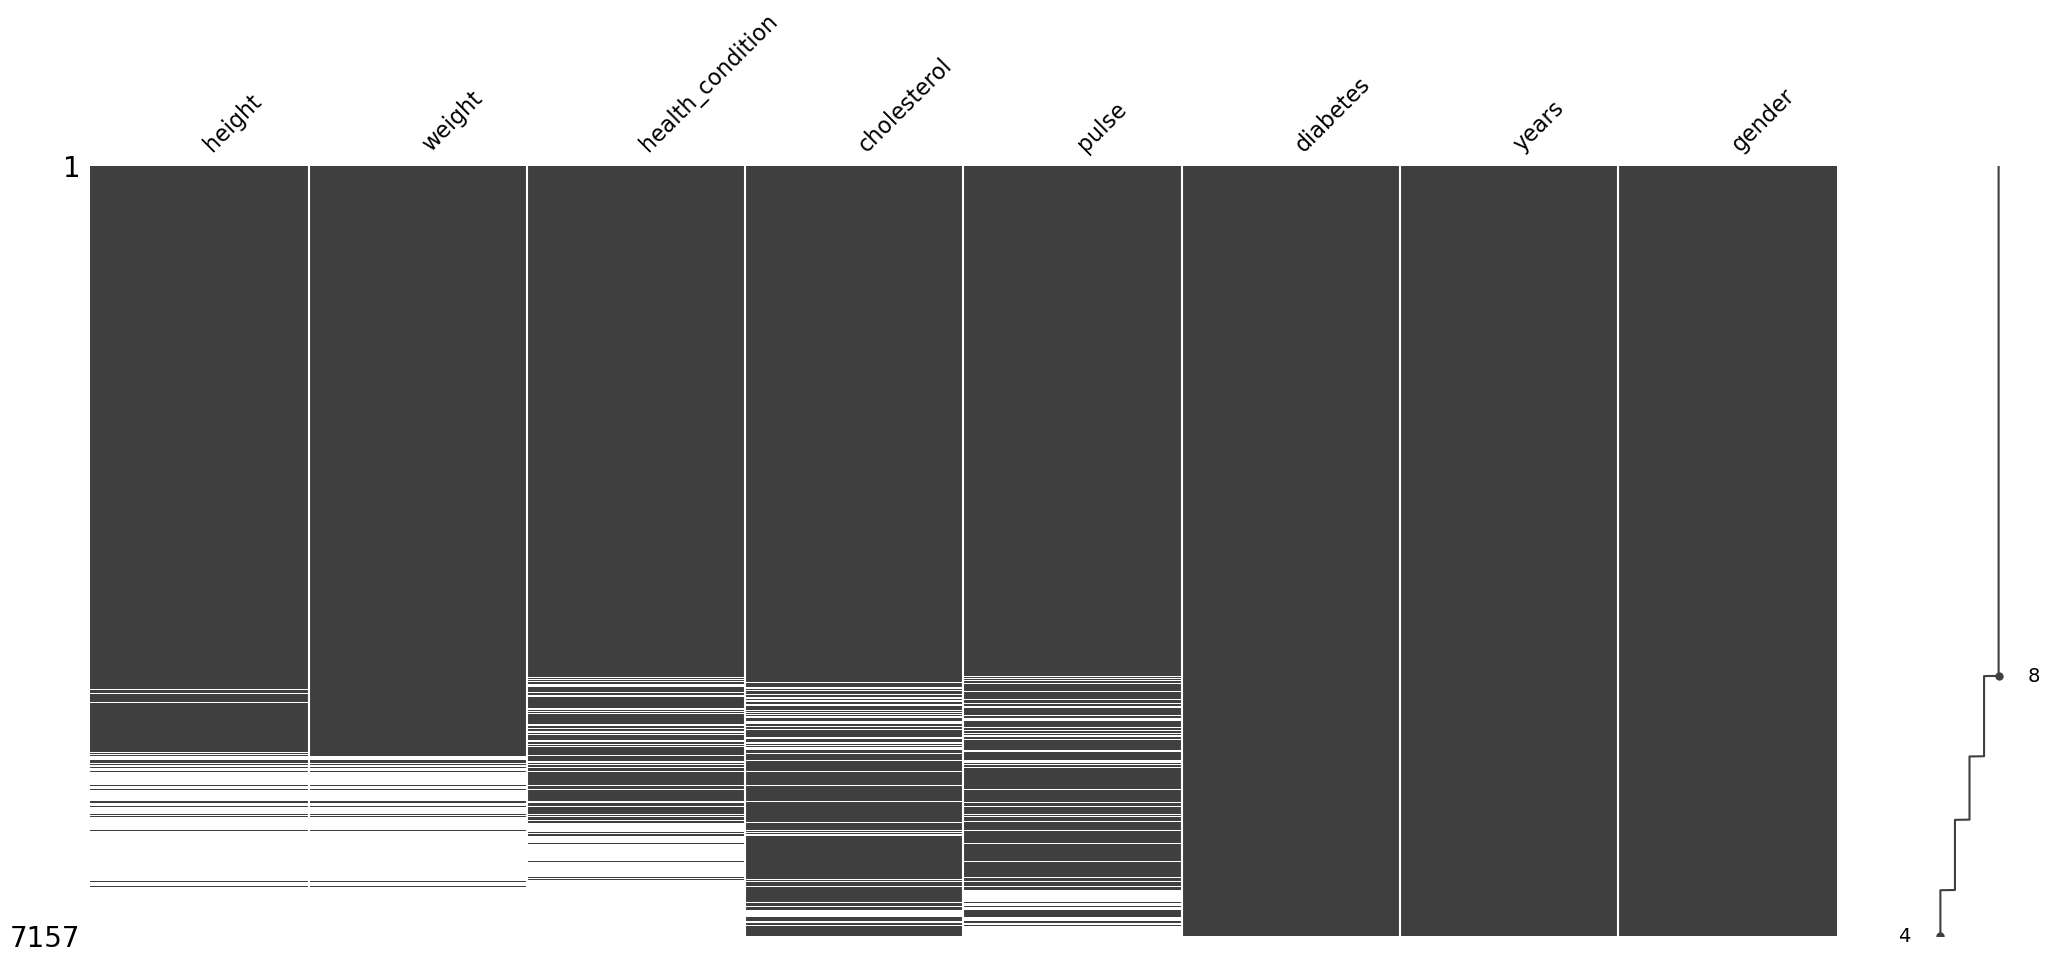

In [3]:
%run 2.1-Imputation_missing_values-data_loaded.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

Existen tres tipos de mecanismos que generan valos faltantes al momento de la recolecció nde datos.

- Missing Completely At Random (**MCAR**): La localización de los valores faltantes en el conjunto de datos ocurre completamente al azar, no dependen de ningún otro dato.
- Missing At Random (**MAR**): La localización de los valores faltantes en el dataset depende de otros valores observados.
- Missing Not At Random (**MNAR**): La localización de los valores faltantes en el conjunto de datos depende de los valores faltantes en sí mismos.

Dependiendo del mecanismos que haya generado los valores faltantes en nuestro conjunto de datos, es el tratamiento que podemos darle, o mal menos nos da una idea de que podemos hacer.

![Missing data action](./imgs/missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

- `two-sided`: las **medias** de las distribuciones subyacentes a las muestras son **desiguales**
- `less`: la **media** de la distribución subyacente a la **primera** muestra es **menor** que la media de la distribución subyacente a la **segunda** muestra.
- `greater`: la **media** de la distribución subyacente a la **primera** muestra es **mayor** que la media de la distribución subyacente a la **segunda** muestra.


In [4]:
female_weight_df, male_weight_df = (
  nhanes_df
  .select_columns("gender", "weight")
  .transform_column(
    "weight",
    lambda x: x.isna(),
    elementwise = False
  )
  .groupby("gender")
  .weight
  .pipe(
    lambda df: (
      df.get_group("Female"),
      df.get_group("Male")
    )
  )
)

Para el ejemplo se quiere verificar si existe una diferencia entre la ausencia o presencia de valores en la medición del peso respecto a a categoría del genero.

Si obtenemos un $p\text-value$  $>0.05$ no se rechaza la hipotesis de que exista una diferencia en la media de las muestras.

In [5]:
ttest_ind(
  a = female_weight_df,
  b = male_weight_df,
  alternative = "two-sided"
)

TtestResult(statistic=-1.3739621981597756, pvalue=0.16949645797671714, df=7155.0)

Al hacer la prueba T-test obtenemos un $p\text-value$ de $0.1694 > 0.05$, por lo tanto no se rechaza la hipotesis de que existe una diferencia entre los pacientes que tienen valores faltantes en la medición del peso, se puede concluir que los valores faltantes de la variable `weight` son **MAR**.

## Visualización valores faltantes en variables categóricas

Buscaremos la relación entre la condición de salud (`health_condition`) y el genero (`gender`) en la ausencia de valores de la medición del peso (`weight`) del paciente.

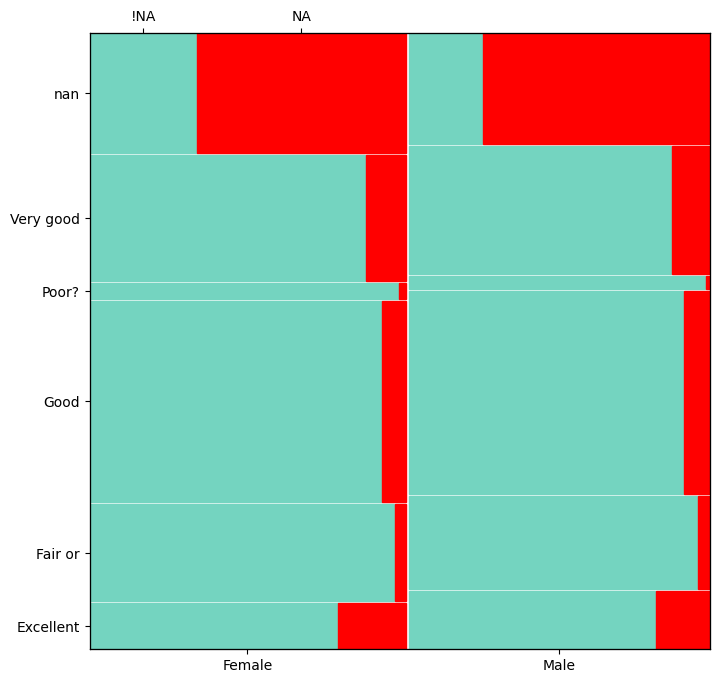

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
(
  nhanes_df
  .select_columns("weight", "health_condition", "gender")
  .assign(
    weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
  )
  .groupby(
    ["gender", "health_condition", "weight"],
    dropna=False, # Visualizar los valores faltantes
    as_index=True # Regresa las variables agrupadas como Index.
  )
  .size()
  .pipe(
    lambda df: mosaic(
      data=df,
      properties=lambda key: {"color": "r" if "NA" in key else "#74d4c0"},
      axes_label=True,
      horizontal=True,
      labelizer=lambda key: "",
      ax=ax
    )
  )
);

Observaciones:
- Las personas (tanto hombres como mujeres) con una condición de salud pobre tienen la menor cantidad de valores faltantes en la medición del peso.
- Sin embargo, las personas con un estado de saludo Excelente son los que tienen mayor cantidad de valores faltantes en la medición del peso.
- En cambio cuando no esta registrada la condición salud podemos encontrar pocas mediciones de peso.

## Tratamiento de variables categóricas para imputación de valores faltantes

Creamos una copia independiente del DataFrame original para no modificar los datos una vez codificadas las variables categóricas.

In [7]:
nhanes_transform_df = nhanes_df.copy(deep=True)

### Codificación ordinal

Una codificación **ordinal** implica mapear cada categoría única en un valor numérico entero.

#### Ejemplo

Dado un dataset de datos con dos categorías, encontraremos los valores únicos por categoría y los transformaremos utilizando una códificación ordinal.

In [8]:
encoder = OrdinalEncoder() # Creamos una instancia del encoder.
X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [9]:
encoder.fit_transform(X) # Ajusta y transforma los datos

array([[1.],
       [0.],
       [0.]])

In [10]:
encoder.categories_ # Nos regresa las categorías que previamente codificó

[array(['Female', 'Male'], dtype=object)]

In [11]:
encoder.inverse_transform([[1], [0]])

array([['Male'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas las variables categóricas del DF

Seleccionamos las columnas categóricas que queremos transformar.

In [12]:
categorical_vars = nhanes_transform_df.select_dtypes(include=[object, "category"]).columns

Creamos el transformer que aplicará la codificación ordinal con la función `OrdinalEncoder`

In [13]:
categorical_transformer = make_column_transformer(
  (OrdinalEncoder(), categorical_vars),
  remainder="passthrough" # Le dice al coficiador que manenga intactas las otras columnas del DF 
)

Creamos un nuevo DF con las columnas categóricas ya codificadas.

In [14]:
nhanes_transform_df = (
  pd.DataFrame(
    categorical_transformer.fit_transform(nhanes_df),
    columns=categorical_transformer.get_feature_names_out(),
    index=nhanes_df.index
  )
  .rename_columns(
    function = lambda x: x.removeprefix("ordinalencoder__")
  )
  .rename_columns(
    function = lambda x: x.removeprefix("remainder__")
  )
)

#### Aplicando one-hot encoder

Copiamos el DataFrame original en otro espacio en memoria.

In [15]:
nhanes_OH_transformed_df = nhanes_df.copy(deep=True)

Creamos el transformer:
- A la variable categórica `gender` se le aplica una codificacióon ordinal al solo manejar dos categorías distintas,
- Aplicamos la codificación one-hot a la variable `health_condition` al manejar más categorías.

In [16]:
transformer = make_column_transformer(
  (OrdinalEncoder(), ["gender"]),
  (OneHotEncoder(), ["health_condition"]),
  remainder="passthrough"
)

In [17]:
nhanes_OH_transformed_df = (
  pd.DataFrame(
    transformer.fit_transform(nhanes_df),
    columns=transformer.get_feature_names_out(),
    index=nhanes_df.index
  )
  .rename_columns(
    function = lambda x: x.removeprefix("ordinalencoder__")
  )
  .rename_columns(
    function = lambda x: x.removeprefix("remainder__")
  )
  .rename_columns(
    function = lambda x: x.removeprefix("onehotencoder__")
  )
)

nhanes_OH_transformed_df.head(10)

,gender,health_condition_Excellent,health_condition_Fair or,health_condition_Good,health_condition_Poor?,health_condition_Very good,health_condition_nan,height,weight,cholesterol,pulse,diabetes,years
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,68.0,135.0,182.0,68.0,0.0,18.0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,165.0,184.0,90.0,0.0,67.0
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,60.0,210.0,230.0,90.0,1.0,54.0
11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,68.0,154.0,180.0,66.0,0.0,71.0
12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,62.0,170.0,225.0,58.0,0.0,61.0


Ver las categorías que utilizóel transformador:

In [18]:
(
  transformer
  .named_transformers_
  .get("onehotencoder")
  .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

Conocer una categoría por el valor codificado:

In [19]:
(
  transformer
  .named_transformers_
  .get("onehotencoder")
  .inverse_transform(
    X=[[0, 1, 0, 0, 0, 0]]
  )
)

array([['Fair or']], dtype=object)

## Métodos de imputación basados en el donante

Entre este tipo de métodos encontramos:
- Imputar una constante
- Imputar valores estadísticos: Media, moda o mediana
- Llenado hacia atrás
- Llenado hacia adelante
- Interpolación

### Imputación por interpolación

Este método de imputación es un proceso para estimar los puntos de los valores faltantes a partir de puntos conocidos mediante métodos de interpolación matemática.

La idea es utilizar los valores conocidos que están antes y después de un valor faltante para estimar su posible valor.

Importamos el conjunto de datos:

In [20]:
airquality_df = (
  sm.datasets.get_rdataset("airquality")
  .data
  .clean_names(
    case_type="snake",
  )
  .add_column("year", 1973)
  .assign(
    date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
  )
  .sort_values(by="date")
  .set_index("date")
)
airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


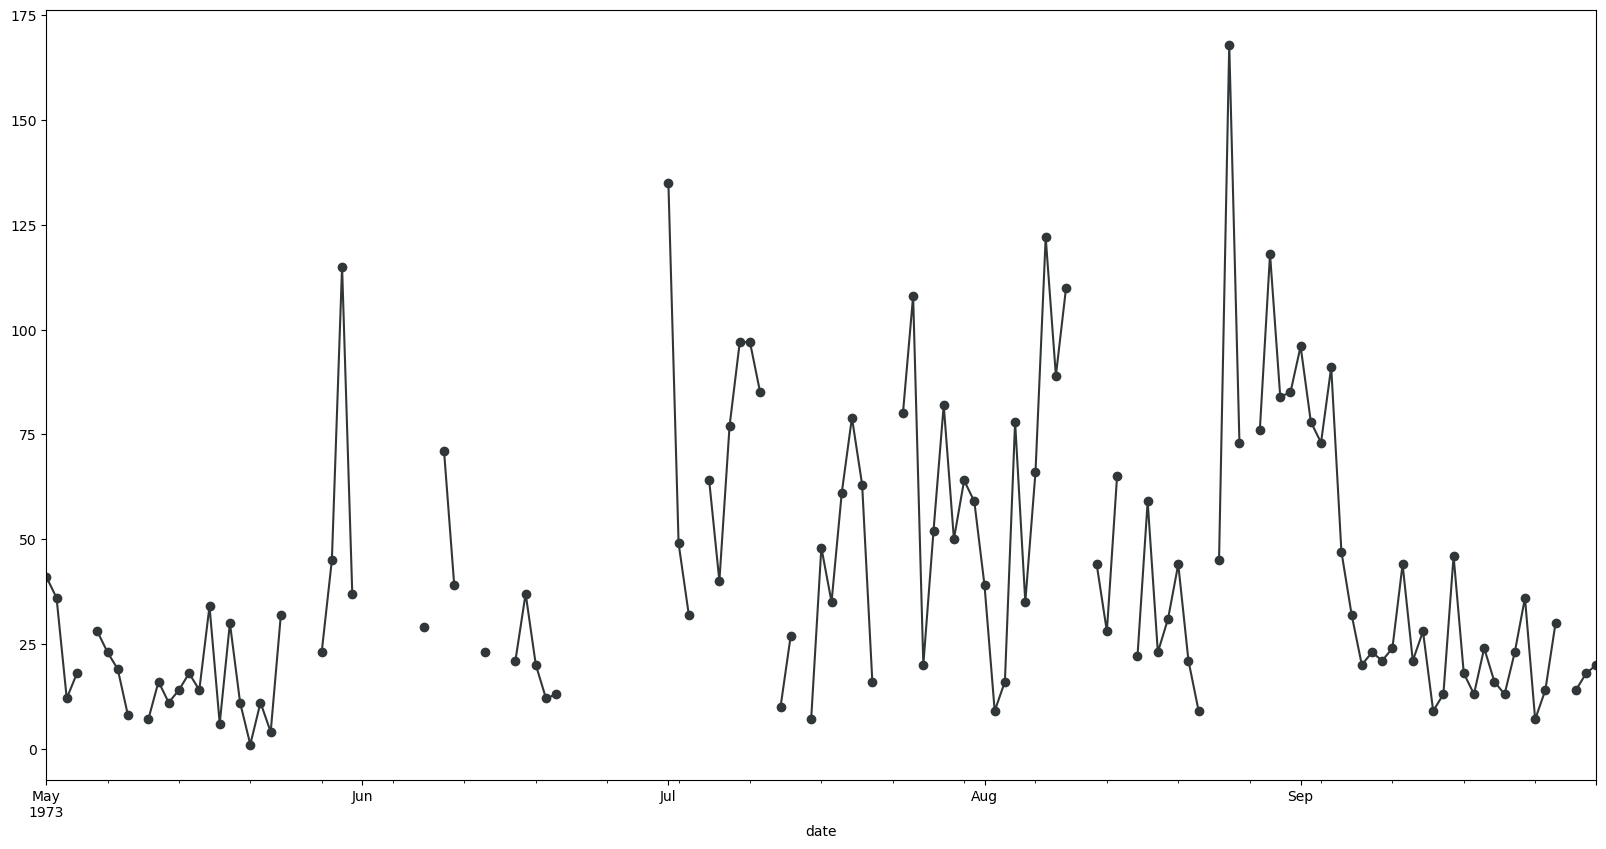

In [21]:
plt.figure(figsize=(20,10))
(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

En la serie temporal del valor de la variable `ozone` se observan cortes entre puntos, estos cortes indican la ausencia de valores en el dataset.

A continuación visualizamos una imputación con llenado hacia adelante y atrás:

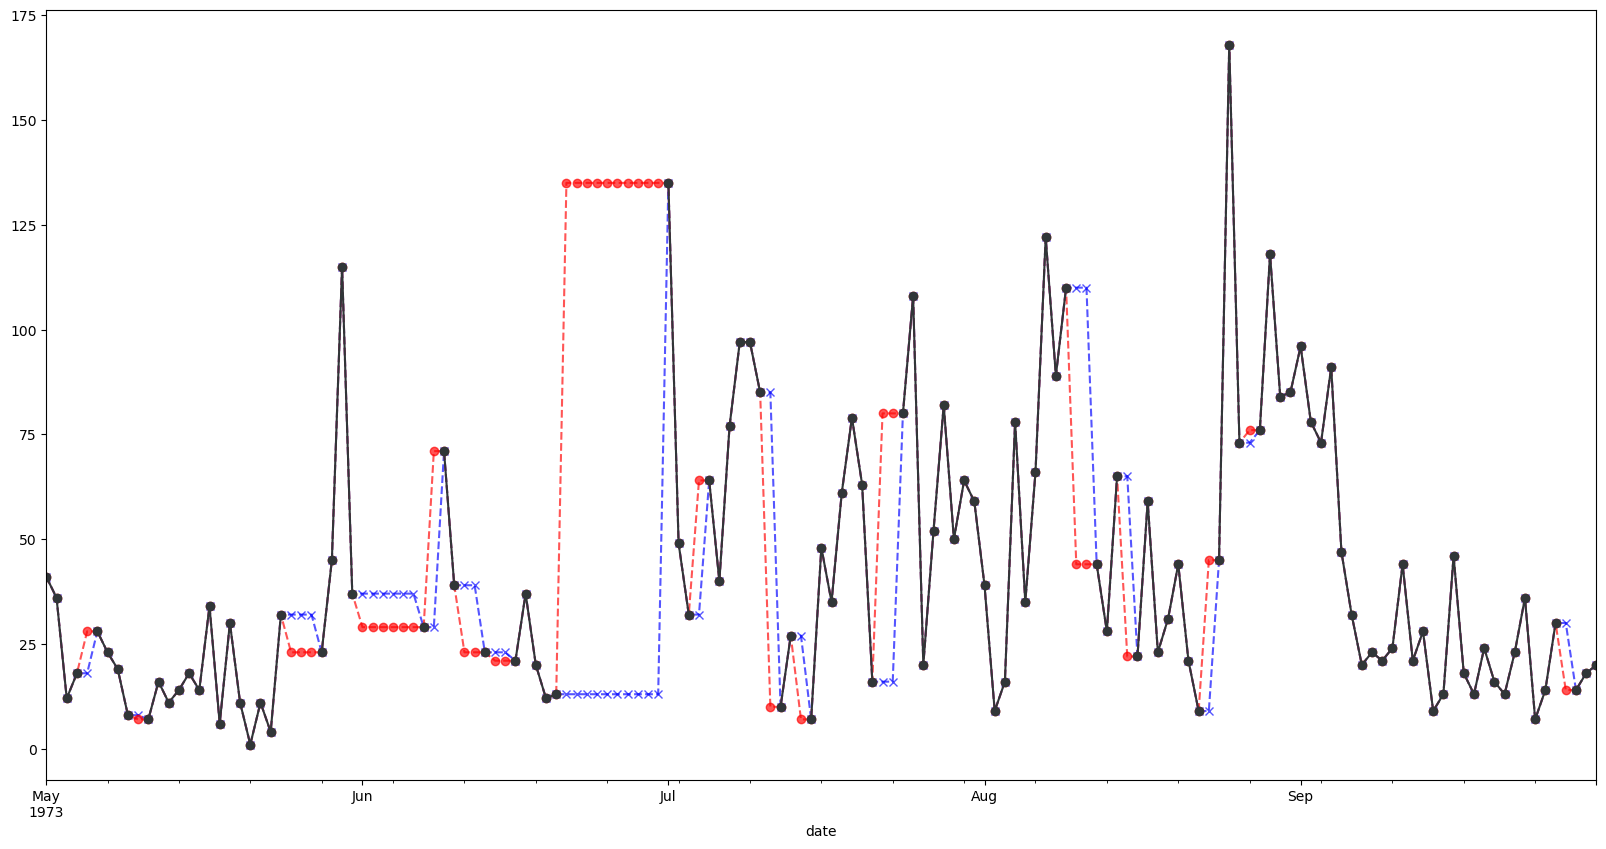

In [22]:
plt.figure(figsize=(20,10))

(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].ffill().plot(color="b", alpha=6/9, linestyle="dashed", marker="x"),
      df["ozone"].bfill().plot(color="r", alpha=6/9, linestyle="dashed", marker="o"),
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

Visualización de una imputación por interpolación lineal:

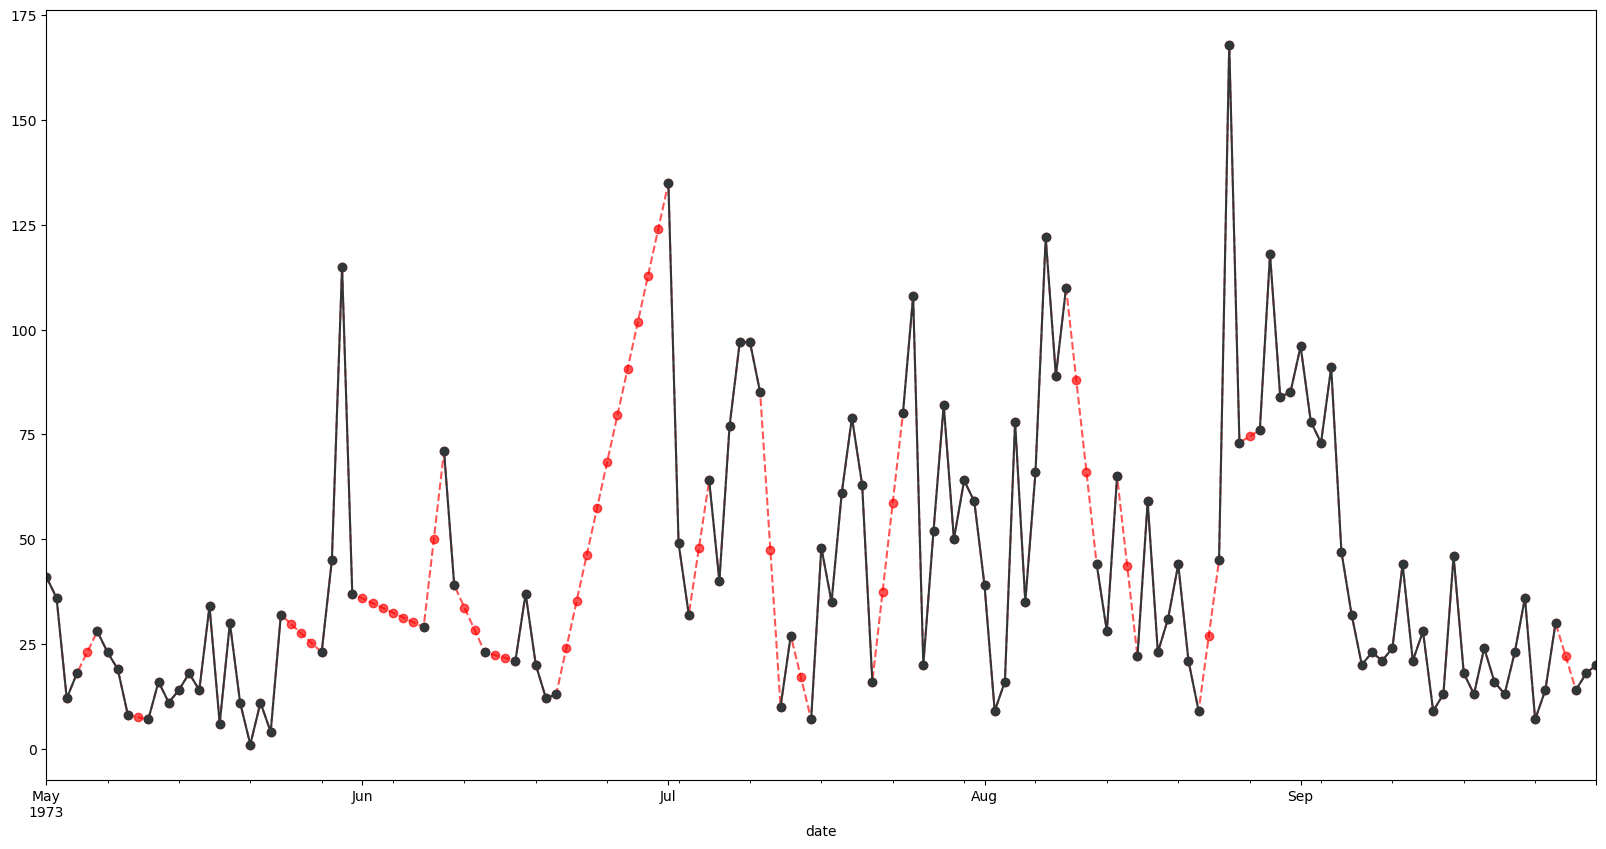

In [23]:
plt.figure(figsize=(20,10))

(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].interpolate(method="linear").plot(color="r", alpha=6/9, linestyle="dashed", marker="o"),
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

Visualización de una imputación por interpolación del vecino más cercano:

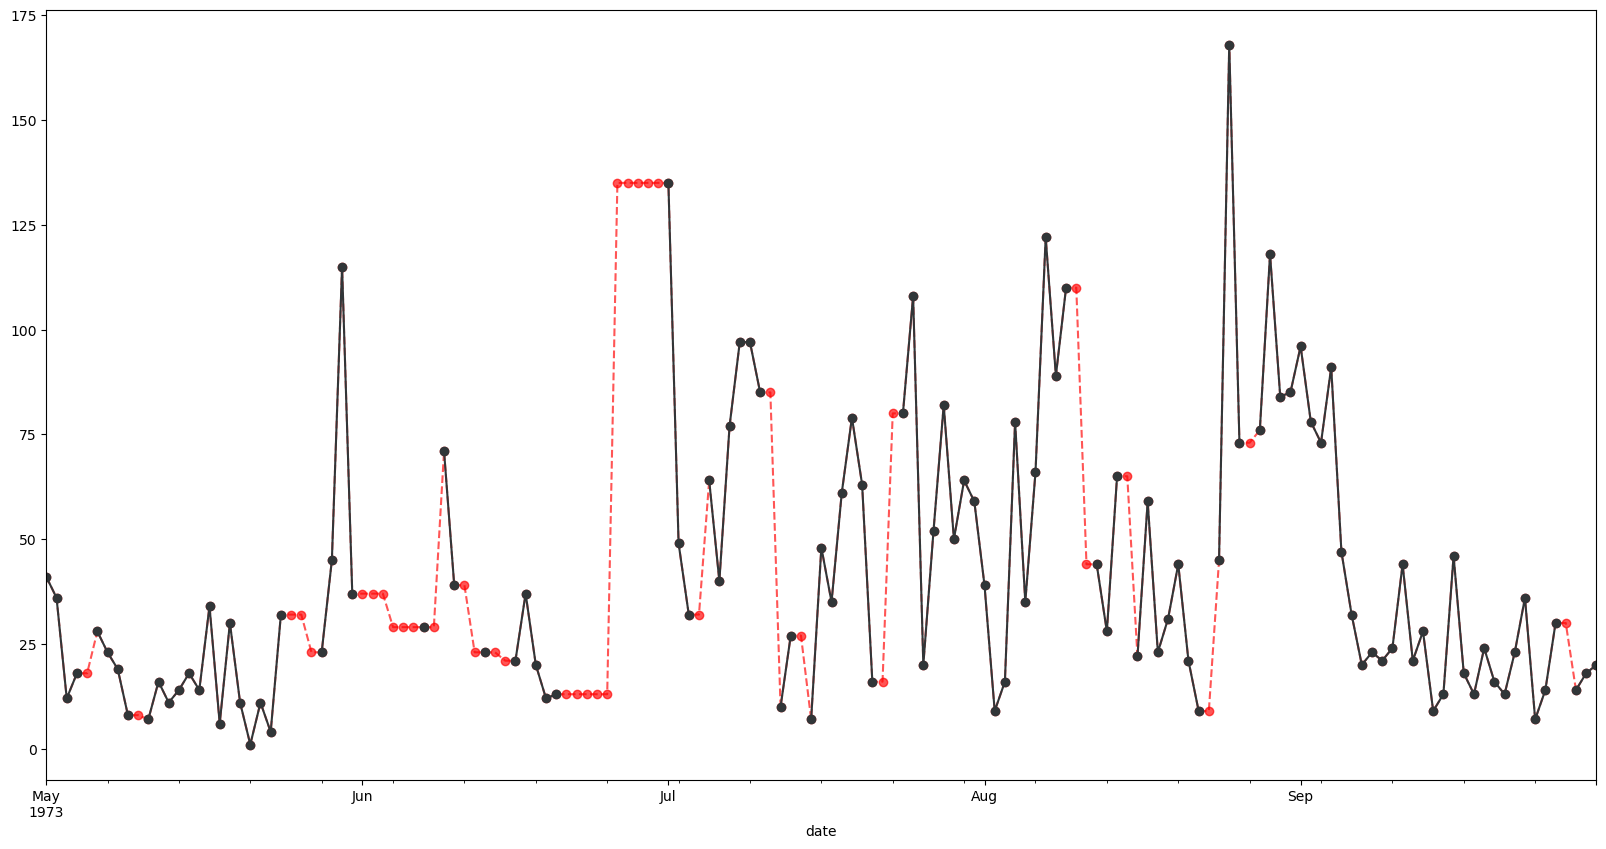

In [24]:
plt.figure(figsize=(20,10))

(
  airquality_df
  .select_columns("ozone")
  .pipe(
    lambda df: (
      df["ozone"].interpolate(method="nearest").plot(color="r", alpha=6/9, linestyle="dashed", marker="o"),
      df["ozone"].plot(color="#313638", marker="o")
    )
  )
)
plt.show()

Grácias a la previsualización de la interpolación aplicanto los método `linear` y `nearest`, podemos concluir que el mejor método o que más se ajusta a los datos es `linear` al no agregarle tanta variabilidad a los datos, entonces procedemos a imputar los datos a la variable `ozone` con este método.

In [25]:
airquality_df["ozone"] = airquality_df["ozone"].interpolate(method="nearest")
airquality_df["ozone"].isna().sum()

0